# `<Title>`

Authors:
- Carson Jan
- Ken Yang
- Xiaoheng Wang
- Yunle Xu

DSCI 100 003 <br>
Project Final Report <br>
Group 30

---
# Introduction
## Background infomation on the topic
The project focuses on data from a MineCraft research server set up by UBC Computer Science. The server records player actions, and the goal is to address practical challenges:

1. Player Recruitment: Identifying which types of players contribute the most data to target recruitment effectively.
2. Resource Allocation: Predicting player activity to manage server resources like hardware and licenses.

The main question is: “Which kinds of players are most likely to contribute a large amount of data?”

Using a Jupyter Notebook, the project will clean data, explore patterns, build predictive models, and document results for actionable insights.

## Posted question
We choose the first question: We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.

In other words:
Can we create a accurate redictor of a user's playtime given its information (age, gender, etc...)? If so, what characteristics do players with high playtime have?


## Description of the dataset used
|variable Name|Type|Description|
|---|---|---|
|hashedEmail|character|A hashed version of the player’s email, used to anonymize player identity|
|start_time|character|The start time of the player’s session (needs to be converted to date-time format)|
|end_time|character|The end time of the player’s session (needs to be converted to date-time format)|
|original_start_time|numeric|The exact start time recorded as a timestamp|
|original_end_time|numeric|The exact end time recorded as a timestamp|

|variable Name|Type|Description|
|---|---|---|
|hashedEmail|character|A hashed version of the player’s email, used to anonymize player identity|
|start_time|character|The start time of the player’s session (needs to be converted to date-time format)|
|end_time|character|The end time of the player’s session (needs to be converted to date-time format)|
|original_start_time|numeric|The exact start time recorded as a timestamp|
|original_end_time|numeric|The exact end time recorded as a timestamp|
|experience|character|Player's level of experience (e.g., Pro, Veteran)|
|subscribe|logical|Whether the player has a subscription (TRUE/FALSE)|
|hashedEmail|character|The hashed email of the player to ensure anonymity|
|played_hours|double|Total hours the player has played|
|name|character|The player's name|
|gender|character|The player's gender|
|age|double|The player's age|
|individualId|logical|Indicator of whether the player has an individual ID|
|organizationName|logical|Name of the organization associated with the player|

---
# Methods & Results

## Methods used

    1）Data Cleaning:

Combined *players.csv* and *sessions.csv* where needed to include player characteristics and session-related details in a single dataset.

 -> Filtered out unnecessary columns (hashedEmail, name, individualId, organizationName) to optimize for data size
 
 -> Mapped the reported experience levels to numeric values (From Beginner = 1 To Veteran = 5)
 
 -> Log-transformed played_hours to address skewness, as some players played for > 100 Hours

 -> Converted subscribe (logical TRUE/FALSE) into numeric binary values (TRUE = 1, FALSE = 0) for use in regression and modeling.

 -> Use one hot encoding on gender. ie: seperate into separate columns (e.g., gender_Male, gender_Female) of 1 and 0s. We also found that we have to exclude the only one data point which gender=Other, as it will cause bugs in the scalling process when we are building the recipe for our regression model.

    2) Data Visualization:

 -> Visualizing data using bar charts, scatterplots, and boxplots

    3) Statistical Analysis:
    
 -> Compare mean played_hours across experience levels.

 -> Checking correlations between played_hours and age.

Libraries: tidyverse, tidymodels, gridExtra.*******
Techniques: Log transformations, one-hot encoding.

## Code

#### Libraries/ initialization

In [1]:
library(tidyverse)
library(tidymodels)
library(tidyclust)
library(gridExtra)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

#### Load data

In [2]:
players <- read_csv('data/players.csv')
head(players)

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,NA,NA
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,NA,NA
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA,NA


#### Wrangle & Clean data

In [3]:
mapping_exp <- c("Beginner" = 1, "Amateur" = 2, "Regular" = 3,
                 "Pro" = 4, "Veteran" = 5)
mapping_gender <- c("Male" = 1, "Female" = 2, "Non-binary" = 3,
                 "Agender" = 4, "Two-Spirited" =5, "Other" = 6, "Prefer not to say"=7)

players_clean <- players |>
    mutate(experience2 = as.integer(mapping_exp[experience])) |>
    mutate(subscribe2 = as.integer(subscribe)) |>
    mutate(gender2=as.integer(mapping_gender[gender])) |>
    mutate(gender3=gender) |> mutate(value=1) |> #one hat encoding: this and next line
    pivot_wider(names_from=gender3, names_prefix='gender_', values_from=value, values_fill=0) |> 
    select(-hashedEmail, -name, -individualId, -organizationName) |>
    filter(gender_Other != 1)
    #rm data not important to Qs/NA, rm gender=Other as there is only 1 dp for such var


head(players_clean, 3)


experience,subscribe,played_hours,gender,age,experience2,subscribe2,gender2,gender_Male,gender_Female,gender_Non-binary,gender_Prefer not to say,gender_Agender,gender_Two-Spirited,gender_Other
<chr>,<lgl>,<dbl>,<chr>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Pro,TRUE,30.3,Male,9,4,1,1,1,0,0,0,0,0,0
Veteran,TRUE,3.8,Male,17,5,1,1,1,0,0,0,0,0,0
Veteran,FALSE,0.0,Male,17,5,0,1,1,0,0,0,0,0,0


#### Summary of dataset
> exploratory data analysis related to the planned analysis

The dataset provided contained information on player characteristics including (experience, age, gender, subscription) and their total playtime (played_hours)

**Key focus variables:**

- Target: played_hours
- Features: experience, age, subscribe
- Skewness in played_hours was addressed using a log transformation.

<br>

**Planned Analysis**
<br>
Visualizations:
- Histograms for playtime distribution.
- Scatterplots for pairwise relationships (e.g., experience vs. playtime).
- Boxplots to compare variability across groups (e.g., experience levels).


Descriptive Statistics:
<br>
- Summarized average played_hours by experience level and age group.
- Identified trends and potential outliers.
- Key Findings from EDA


Experience Levels:
<br>
- Veterans contributed the most playtime, followed by Pro and Regular players.
- Beginners and Amateurs logged minimal hours, indicating limited engagement.

Age:
<br>
- Younger players (especially below 25) logged more hours but showed greater variability.
- Subscription Status:
- Subscribed players were slightly more active, though the difference was not large.


#### Visualization of dataset 
> exploratory data analysis related to the planned analysis

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


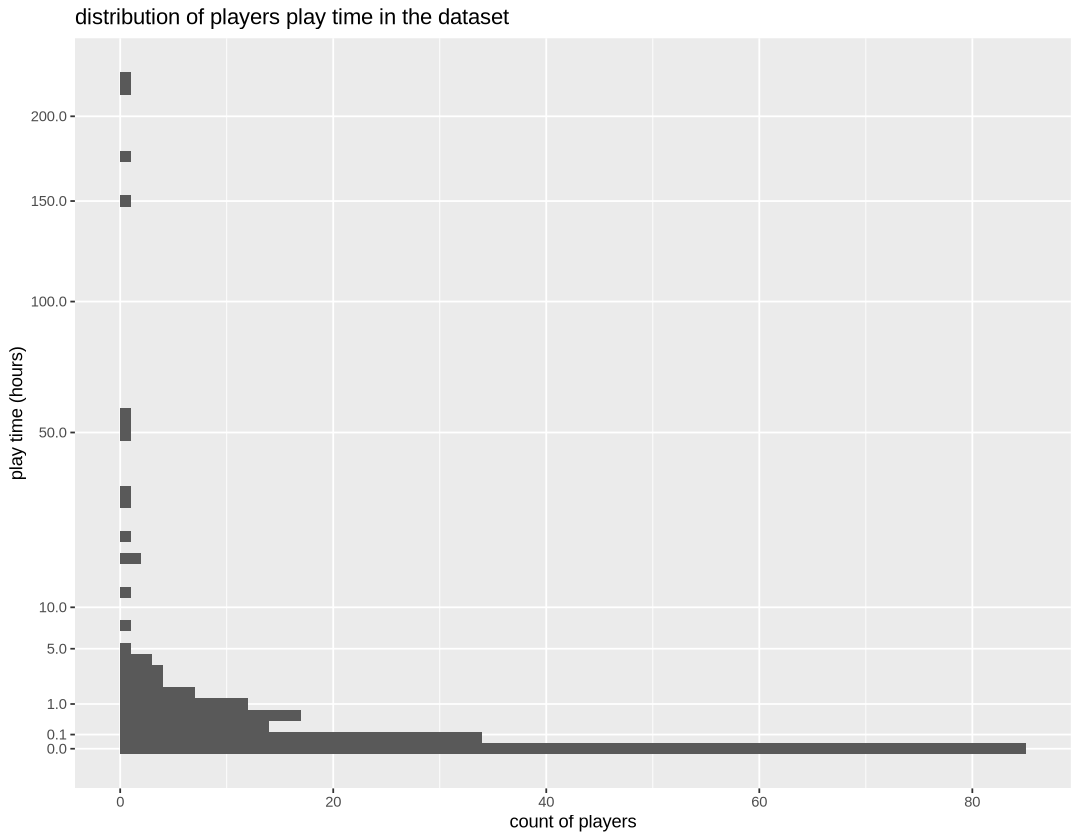

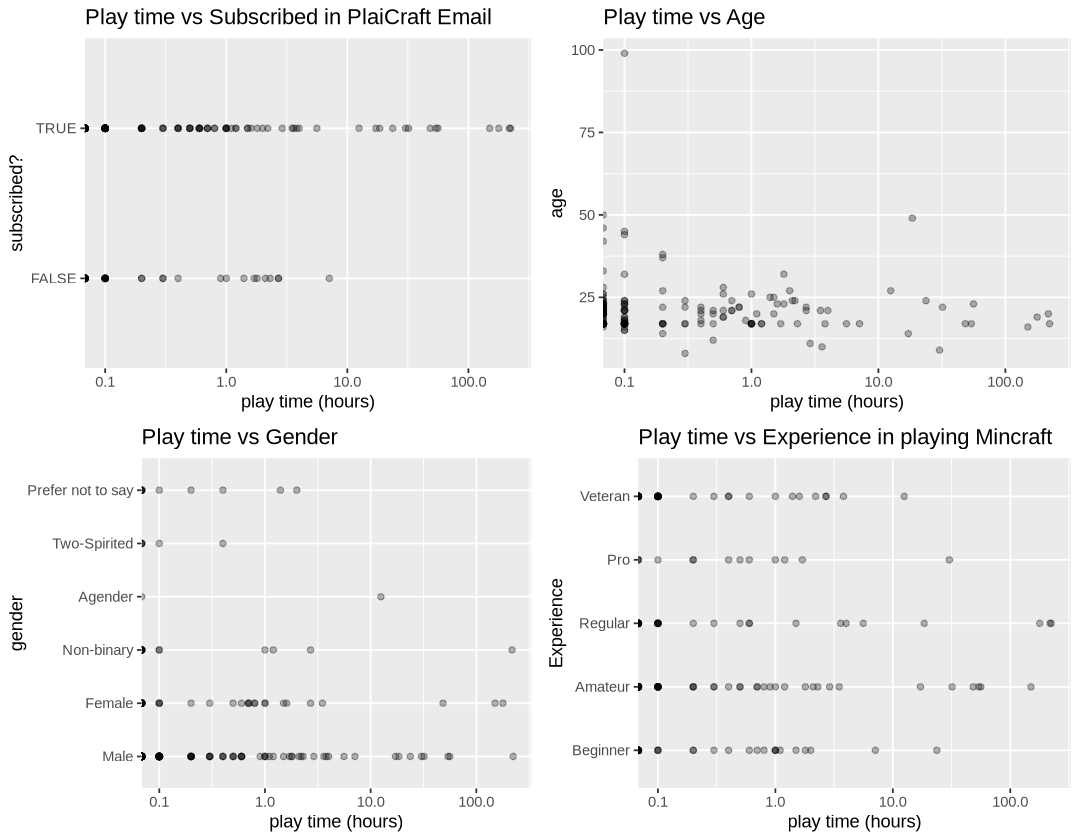

In [4]:
h <- players_clean |>
    ggplot(aes(y=played_hours)) +
    geom_histogram(binwidth=0.25) +
        scale_y_sqrt(breaks = c(0, 0.1 , 1, 5, 10, 50, 100, 150, 200),
                    minor_breaks = NULL) +
    labs(x='count of players', y='play time (hours)', 
         title='distribution of players play time in the dataset')
                    

a <- players_clean |>
    ggplot(aes(x=played_hours, y=age)) +
        geom_point(alpha=0.3) +
        scale_x_log10() + 
    labs(y='age', x='play time (hours)', 
         title='Play time vs Age')


g <- players_clean |>
    ggplot(aes(x=played_hours, 
               y=fct_reorder(gender, gender2))) +
        geom_point(alpha=0.3) +
        scale_x_log10() + 
    labs(y='gender', x='play time (hours)', 
         title='Play time vs Gender')

e <- players_clean |>
    ggplot(aes(x=played_hours, 
               y=(fct_reorder(experience, experience2)))) +
        geom_point(alpha=0.3) +
        scale_x_log10() + 
    labs(y='Experience', x='play time (hours)', 
         title='Play time vs Experience in playing Mincraft')

s <- players_clean |>
    ggplot(aes(x=played_hours, y=subscribe)) +
        geom_point(alpha=0.3) +
        scale_x_log10() + 
    labs(y='subscribed?', x='play time (hours)', 
         title='Play time vs Subscribed in PlaiCraft Email')

options(repr.plot.width=9)
h
grid.arrange(s, a, g, e, ncol=2)

#### Data analysis

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
41,rmse,standard,28.91059,5,7.300945,Preprocessor1_Model41


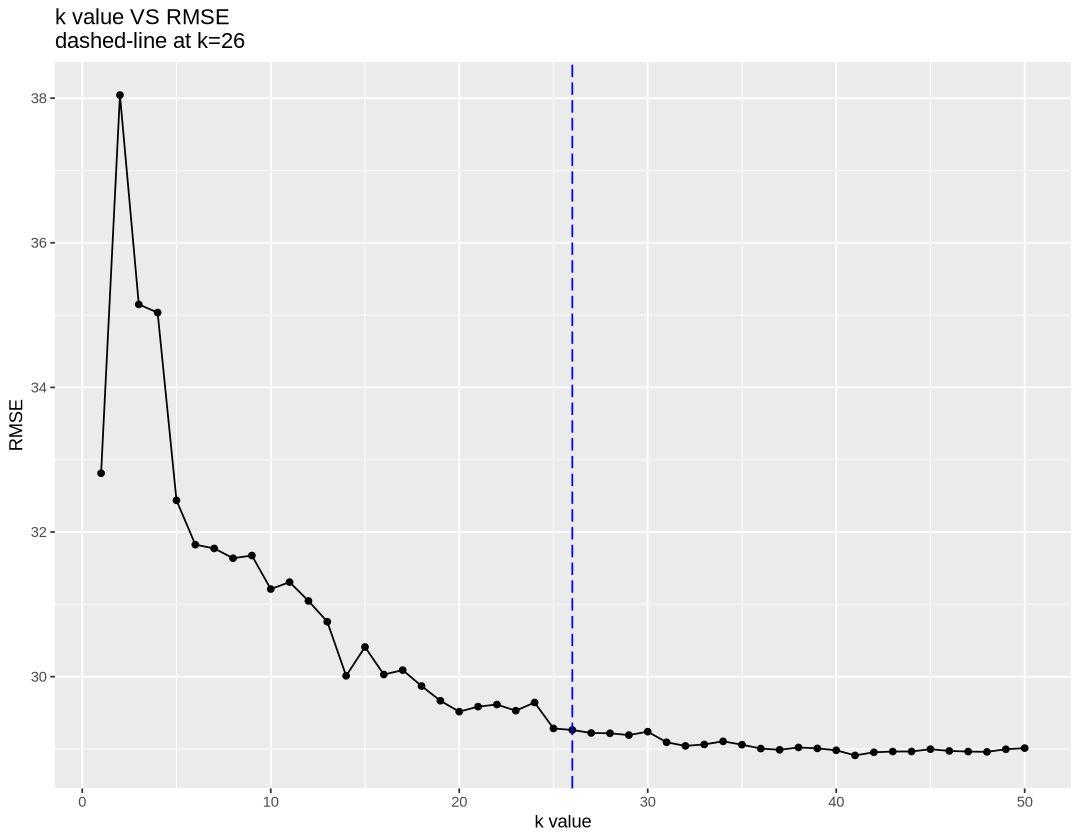

In [5]:
set.seed(1)

players_split <- initial_split(players_clean, prop=0.75, strata=played_hours)
players_training <- training(players_split) |> 
    select(played_hours, 'age':'gender_Two-Spirited', -gender2)
players_testing <- testing(players_split)

recipe_players <- recipe(played_hours ~ ., data=players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

ks <- tibble(neighbors = seq(1,50,1))

players_spec_tune <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |> 
      set_engine('kknn') |>
      set_mode('regression') 

players_vfold <- vfold_cv(players_training, v=5, strata=played_hours)

players_tune <- workflow() |>
    add_recipe(recipe_players) |>
    add_model(players_spec_tune)|>
    tune_grid(resample=players_vfold, grid=ks) |>
    collect_metrics() |>
    filter(.metric=='rmse')

slice_min(players_tune, mean, n=1)

players_tune_plot <- players_tune |>
    ggplot(aes(x=neighbors, y=mean)) +
    geom_point() +
    geom_line() +
    labs(x='k value', y='RMSE', title='k value VS RMSE\ndashed-line at k=26') +
    geom_vline(xintercept = 26, color='blue', linetype = "longdash")

players_tune_plot

##### Choice of k value
Although the k value that yields the minimum RMSE is at k=41, it actually brings similar RMSE as k=25. Therefore, we are going to choose k=26 (to speed up the training process)

In [6]:
set.seed(1)

players_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = 26) |> 
      set_engine('kknn') |>
      set_mode('regression') 

players_fit <- workflow() |>
    add_recipe(recipe_players) |>
    add_model(players_spec)|>
    fit(data=players_training)

players_pred <- players_fit |>
    predict(players_testing) |>
    bind_cols(players_testing)

players_summary <- players_pred |>
    metrics(truth = played_hours, estimate = .pred) |>
    filter(.metric == "rmse")
players_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,9.071435


#### Visualization
> note: all figures should have a figure number and a legend

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


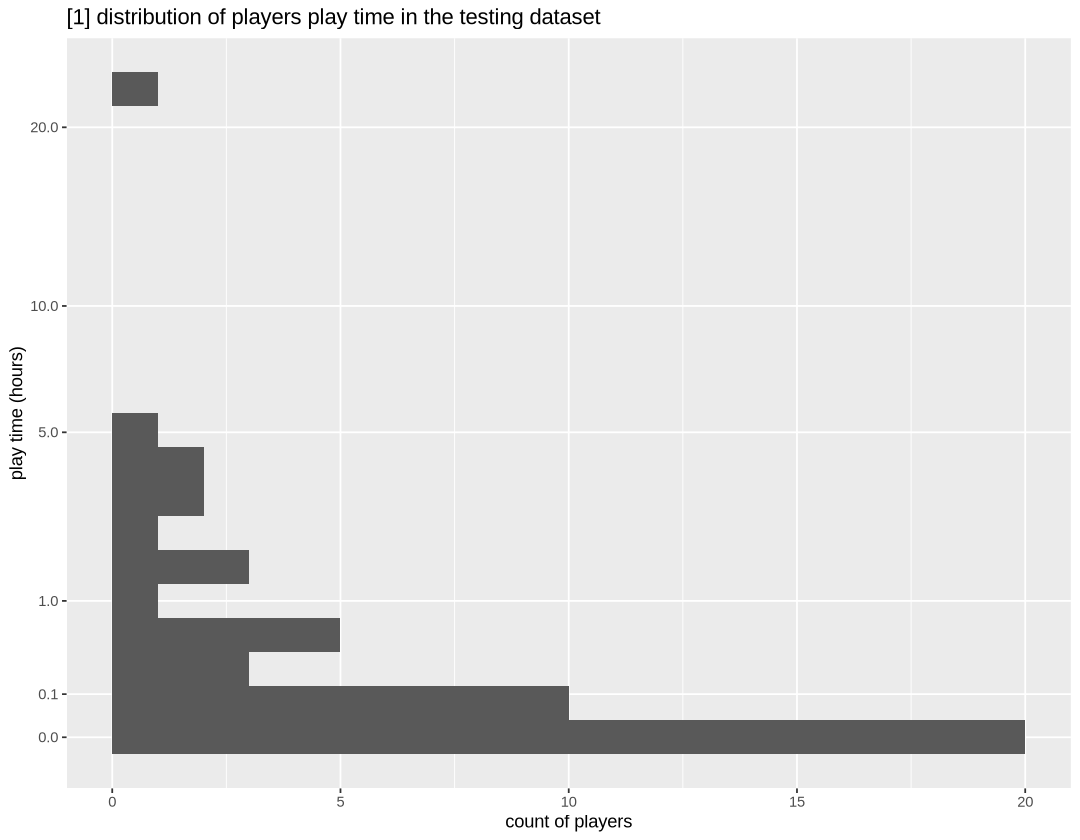

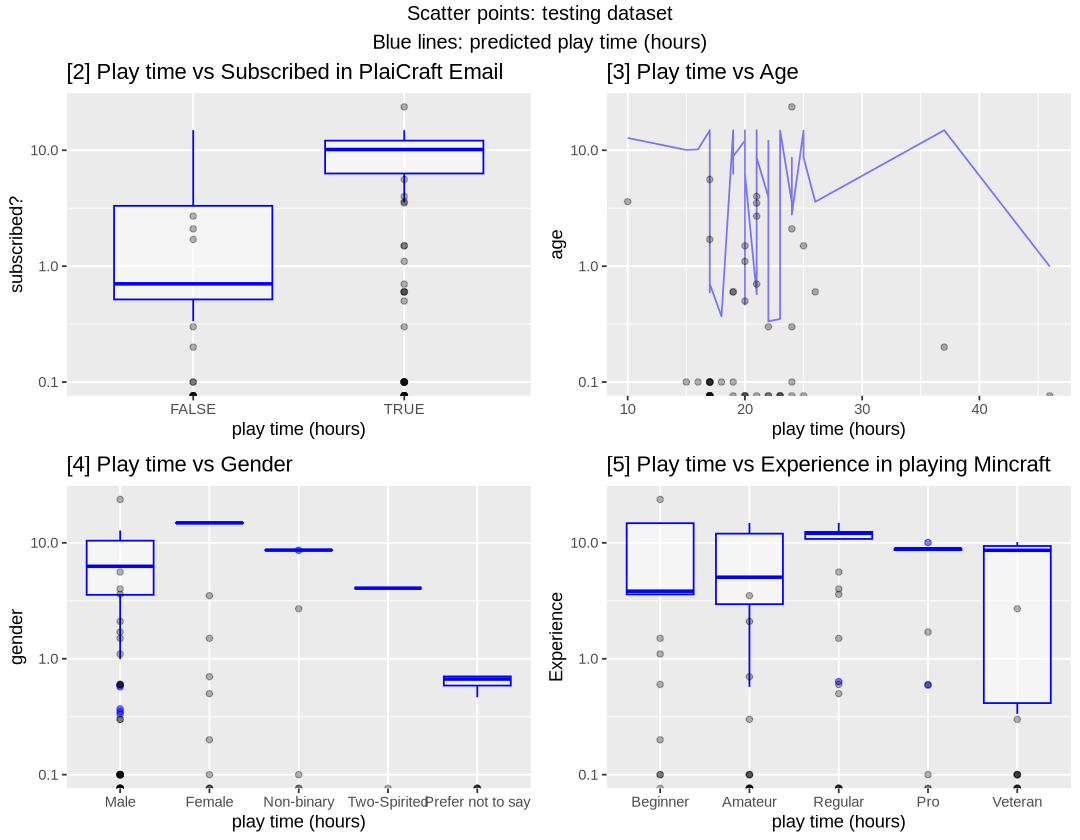

In [8]:
h_pred <- players_pred |>
    ggplot(aes(y=played_hours)) +
    geom_histogram(binwidth=0.25) +
    scale_y_sqrt(breaks = c(0, 0.1 , 1, 5, 10, 20),
                    minor_breaks = NULL) +
    labs(x='count of players', y='play time (hours)', 
         title='[1] distribution of players play time in the testing dataset')

                    

a_pred <- players_pred |>
    ggplot(aes(x=age, y=played_hours)) +
        geom_line(aes(x=age, y=.pred), color='blue', alpha=0.5) +
        geom_point(alpha=0.3) +
        scale_y_log10() +
        labs(y='age', x='play time (hours)', 
         title='[3] Play time vs Age')

g_pred <- players_pred |>
    ggplot(aes(y=played_hours, 
               x=fct_reorder(gender, gender2))) +
        geom_boxplot(aes(x=gender, y=.pred), color='blue', alpha=0.5) +
        geom_point(alpha=0.3) +
        scale_y_log10() +
        labs(y='gender', x='play time (hours)', 
         title='[4] Play time vs Gender')

e_pred <- players_pred |>
    ggplot(aes(y=played_hours, 
               x=(fct_reorder(experience, experience2)))) +
        geom_boxplot(aes(x=experience, y=.pred), color='blue', alpha=0.5) +
        geom_point(alpha=0.3) +
        scale_y_log10() +
        labs(y='Experience', x='play time (hours)', 
         title='[5] Play time vs Experience in playing Mincraft')

s_pred <- players_pred |>
    ggplot(aes(y=played_hours, x=subscribe)) +
        geom_boxplot(aes(x=subscribe, y=.pred), color='blue', alpha=0.5) +
        geom_point(alpha=0.3) +
        scale_y_log10() +
        labs(y='subscribed?', x='play time (hours)', 
         title='[2] Play time vs Subscribed in PlaiCraft Email')

options(repr.plot.width=9)
h_pred
grid.arrange(s_pred, a_pred, g_pred, e_pred, ncol=2,
            top = "Scatter points: testing dataset\nBlue lines: predicted play time (hours)")

---
# Discussion

## Summary of Findings ##
The analysis revealed that female players, subscribed users, players aged 15 to 25, and beginners tend to contribute more data by playing more on the server.

## Was this what you expected to find? ##
Some findings align with expectations. For instance, younger players may have more time and interest in playing, leading to higher activity. The trend of female players contributing more data was less expected but could be influenced by other factors like community engagement or social motivations.

## Impact of Findings ##
These findings are crucial for targeting recruitment efforts. By focusing on younger, female, subscribed, and beginner players, the research team can allocate resources more efficiently and ensure they attract the right kind of participants. It can also help in resource planning for server capacity, ensuring the infrastructure can handle the expected volume of active players.

## Future Questions ##
These results could lead to further questions, such as:
- What motivates these players (e.g., social factors, in-game rewards) to contribute more data?
- How do different player behaviors (e.g., playstyle, frequency) affect the quality of the data contributed?
- Can these patterns be generalized to other games or online platforms?

These questions could guide future studies in understanding player engagement and improving recruitment and resource management in similar projects.

---
# References
> *note to group members: Use APA 7, please*

- GeeksforGeeks. (2024, November 2). One Hot Encoding in Machine Learning. GeeksforGeeks. https://www.geeksforgeeks.org/ml-one-hot-encoding/
- Holtz, Y. (n.d.-a). Boxplot | the R Graph Gallery. https://r-graph-gallery.com/boxplot.html
- Holtz, Y. (n.d.-b). Multiple ggplot2 charts on a single page. https://r-graph-gallery.com/261-multiple-graphs-on-same-page.html
- R - How to one hot encoding a single column while keep other columns still? (n.d.). Stack Overflow. https://stackoverflow.com/questions/52539750/r-how-to-one-hot-encoding-a-single-column-while-keep-other-columns-still
- Sophie. (2019, November 17). How to Combine Multiple GGPlots into a Figure - Datanovia. Datanovia. https://www.datanovia.com/en/lessons/combine-multiple-ggplots-into-a-figure/#combine-multiple-ggplots-using-ggarrange

---
End of report <br>
Finalized and approved by all group member on `<date>`
> *note to group members: run report through grammar check, please*


To be uploaded by `<member>` by `<date>`